## Using results from Hadoop MapReduce/MRJob/Spark to visualize census

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot
import mapclassify
from IPython.display import HTML
from collections import Counter

### Load Geo Shape Data

In [2]:
df_municipalities = gpd.read_file('shape/municipalities_2018.geojson')

In [3]:
# Get shape coordinates for drawing labels
df_municipalities['coords'] = df_municipalities['geometry'].apply(lambda x: x.representative_point().coords[:])
df_municipalities['coords'] = [coords[0] for coords in df_municipalities['coords']]

# Fix some municipalities (faulty names), add a new column with fixed names so they work with census municipalities.

CONVERT = {
    # Municipality Numbers -> Fixed Names
    '821':'Bø (Telemark)',
    '236':'Nes (Akershus)',
    '616':'Nes (Buskerud)',
    '137':'Våler (Østfold)',
    '426':'Våler (Innlandet)',
    '1867':'Bø (Nordland)',
    '441':'Os (Innlandet)',
    '1243':'Os (Hordaland)',
    '713':'Sande (Vestfold)',
    '1514':'Sande (Møre Og Romsdal)',
    
    # Municipality Names -> Fixed Names
    'Guovdageaidnu - Kautokeino':'Kautokeino - Guovdageainnu Suohkan',
    'Kárásjohka - Karasjok':'Karasjok - Kárásjoga Gielda',
    'Unjárga - Nesseby':'Nesseby - Unjárgga Gielda',
    'Deatnu Tana':'Tana - Deanu Gielda',
    'Porsanger - Porsángu - Porsanki':'Porsanger - Porsánjggu Gielda - Porsangin Komuuni',
    'Snåase - Snåsa':'Snåsa - Snåasen Tjielte',
    'Fauske - Fuossko':'Fauske',
    'Loabák - Lavangen':'Lavangen',
    'Hamarøy - Hábmer':'Hamarøy',
    'Divtasvuodna - Tysfjord':'Hamarøy',
    'Storfjord - Omasvuotna - Omasvuo':'Lyngen',
    'Gáivuotna - Kåfjord - Kaivuono':'Lyngen',
    'Snillfjord':'Hitra',
    'Båtsfjord':'Vardø',
    'Fedje':'Austrheim',
    'Utsira':'Karmøy',
    'Rælingen':'Fet',
    'Sula':'Ålesund',
    'Midsund':'Aukra',
}

municipalityNamesUpdated = []
for n, m in zip(df_municipalities.loc[:,'Kommunenum'], df_municipalities.loc[:,'Kommunenav']):
    if str(n) in CONVERT:
        m = CONVERT[str(n)]
    elif str(m) in CONVERT:
        m = CONVERT[str(m)]
    municipalityNamesUpdated.append(m.title())

df_municipalities['Municipality'] = municipalityNamesUpdated

In [4]:
MUNICIPALITIES = set(df_municipalities.Municipality)
MUNICIPALITIES_IDX = { m:i for i, m in enumerate(df_municipalities.Municipality) }

### Methods for Visualizing

In [20]:
def visualize(data, values, title='', cat=False, figPath=None, dontShow=False):        
    fig, ax = plt.subplots(1, figsize=(95,30))
    
    if dontShow:
        plt.ioff()
    
    data.plot(
        column=values,
        cmap='Spectral' if cat else 'YlOrBr',
        legend=True,
        legend_kwds={'loc':2, 'fontsize':25} if cat else None,
        vmin=0.0,
        vmax=(np.ceil(values[values.nonzero()].mean()) if (cat == False) else len(np.unique(values))),
        categorical=cat,
        ax=ax
    )
    
    # Draw municipality labels
    #for _, row in data.iterrows():
        #ax.annotate(s=row['Kommunenav'].upper(), xy=row['coords'], horizontalalignment='center', verticalalignment='center', color='green', alpha=0.95)
    
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    
    if figPath:
        plt.savefig('img/{}.png'.format(figPath), transparent=False, bbox_inches='tight')
        
    if dontShow:
        plt.close()


### Visualizing births from 1800 to 1910

In [23]:
df_births = pd.read_csv('data/census_births.csv', encoding='utf-8', names=['Year', 'Municipality', 'Births'])
df_births.drop([i for i,m in enumerate(df_births.Municipality) if str(m).title() not in MUNICIPALITIES], inplace=True) # Remove invalid municips.
df_births.head()

,Year,Municipality,Births
0,1600,Farsund,1
2,1661,Larvik,1
3,1661,Vestby,1
4,1662,Skien,1
5,1662,Vik,1


In [24]:
def animatePopulationOverTime(df, year_start, year_end, display=False):
    years_of_interest = sorted([int(year) for year in set(df.Year) if year is not '?' and int(year) >= year_start and int(year) <= year_end])
    data = np.zeros((len(years_of_interest), len(df_municipalities)), dtype=np.uint64) # A matrix containing the births for the given year (row) in the respective municipalities (column)
        
    for i, year in enumerate(years_of_interest):
        records = df.loc[df.Year == str(year)]
        for m, c in zip(records.Municipality, records.Births):
            data[i,MUNICIPALITIES_IDX[m]] += c
    
    for i, population in enumerate(data.cumsum(axis=0)):
        year = years_of_interest[i]
        visualize(df_municipalities, population, '{}'.format(year), False, 'birth_{}'.format(year), not display)
        print("Visualized", year, '!')

In [27]:
#animatePopulationOverTime(df_births, 1800, 1910)

In [25]:
HTML('<img src="img/1800_1900_anim.gif">')

### Visualizing 1910 Population Density

In [9]:
df_pop_1910 = pd.read_csv('data/census_population.csv', encoding='utf-8', names=['Municipality', 'Population'])
df_pop_1910.head()

,Municipality,Population
0,Agdenes,4422
1,Alstahaug,5205
2,Alta,5236
3,Alvdal,4519
4,Andøy,4726


In [10]:
pop = np.zeros(len(df_municipalities), dtype=np.uint64)
for m, c in zip(df_pop_1910.Municipality, df_pop_1910.Population):
    pop[MUNICIPALITIES_IDX[m]] = c

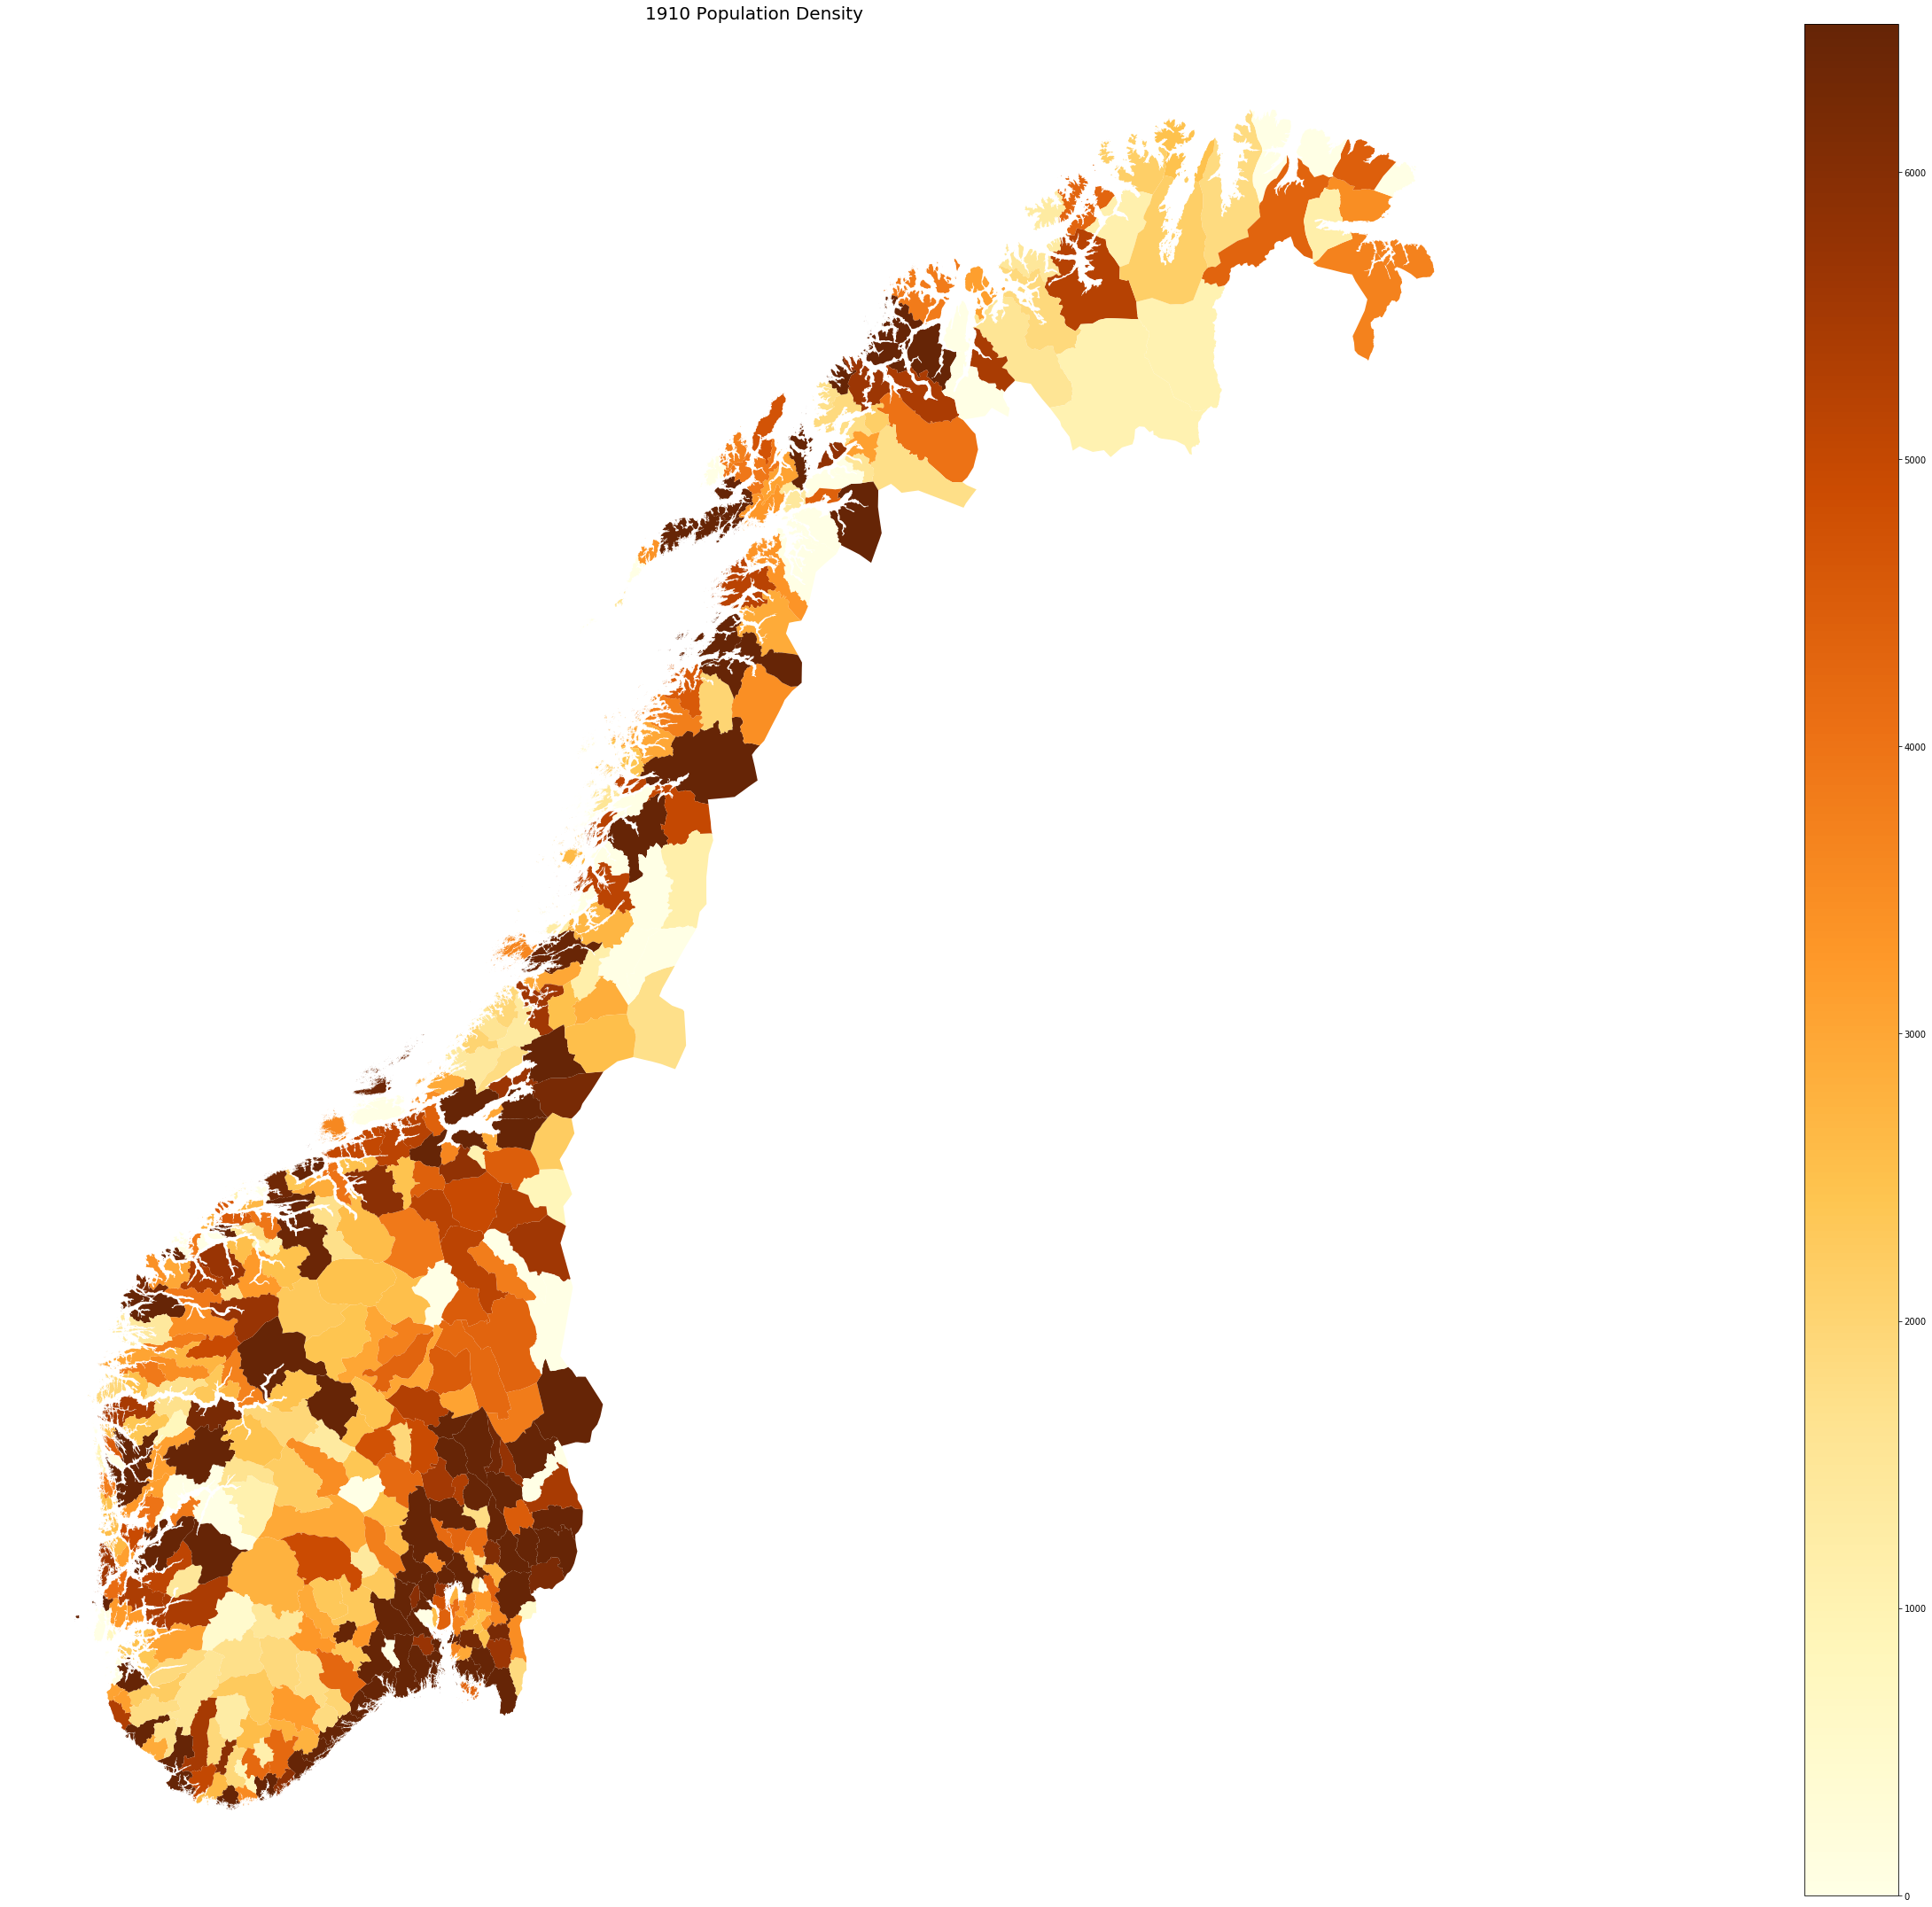

In [11]:
visualize(df_municipalities, pop, '1910 Population Density', False, '1910_img_test')

In [12]:
#df_municipalities.loc[df_municipalities.Municipality == 'Oslo'].plot()

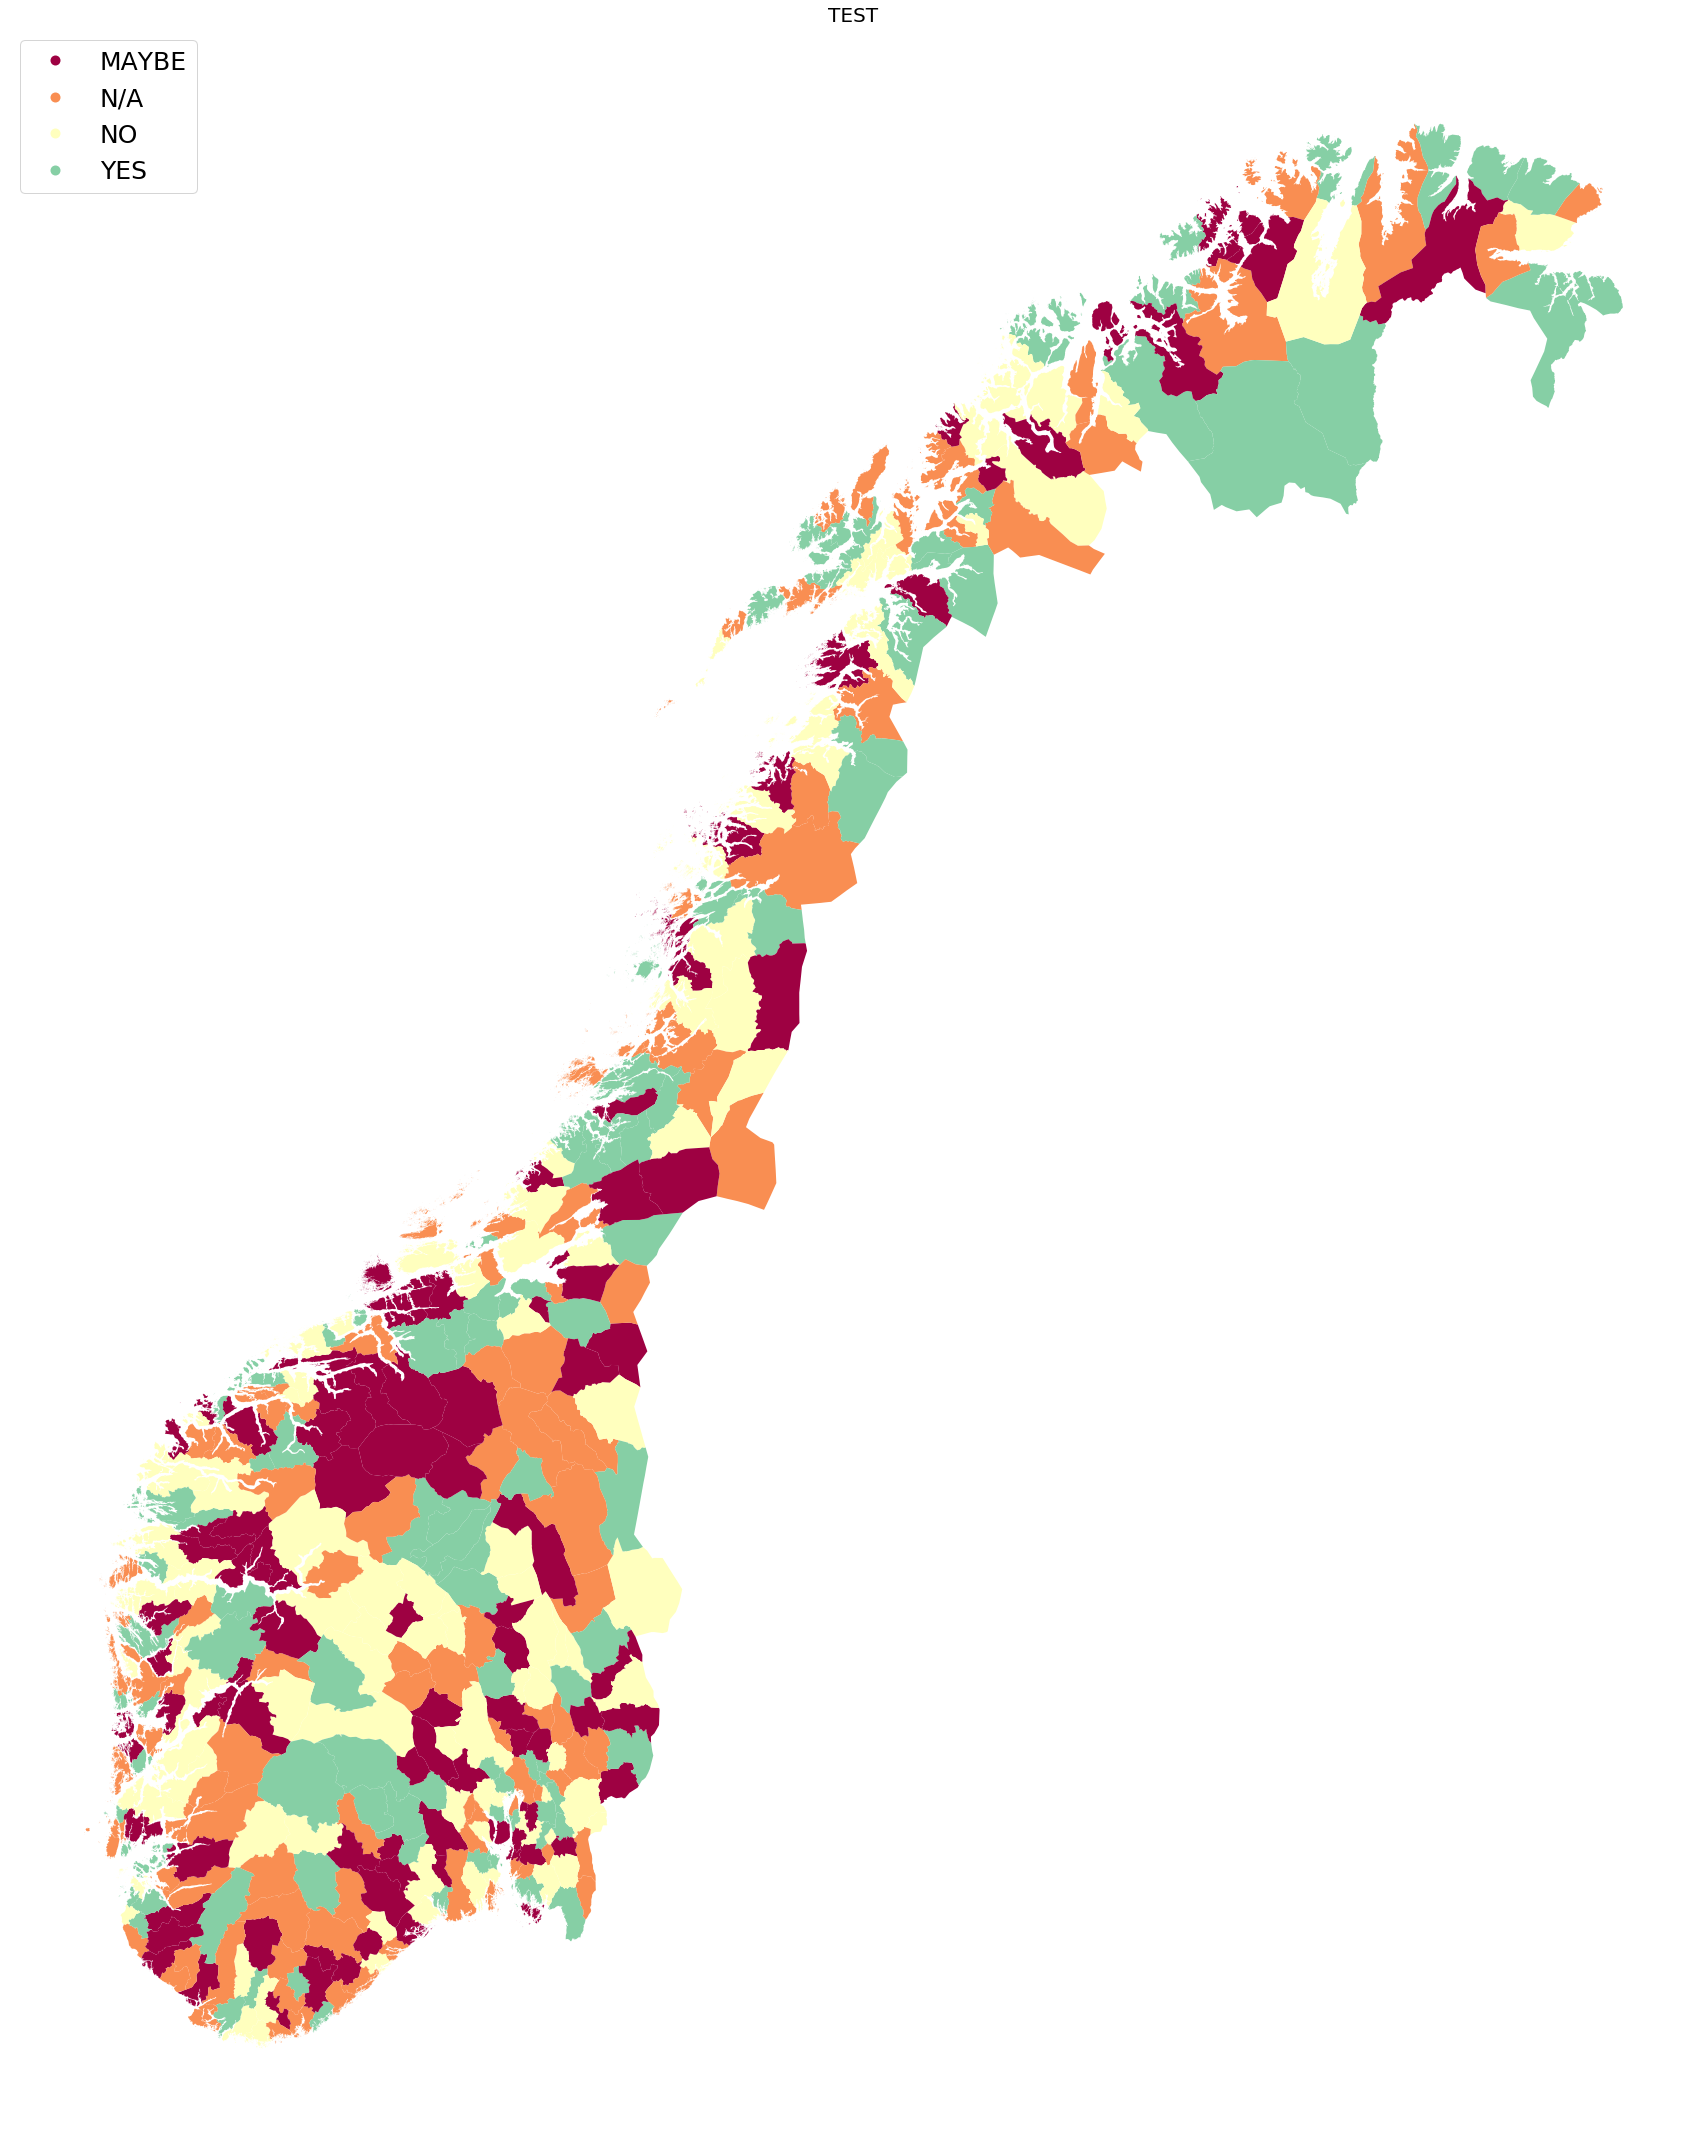

In [13]:
visualize(df_municipalities, np.array([np.random.permutation(['YES', 'NO', 'MAYBE', 'N/A'])[0] for _ in range(len(df_municipalities))]), 'TEST', True)